In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from IPython.display import clear_output

from io import BytesIO, StringIO
import os
import boto3
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

import nltk
import demoji
import google_play_scraper
from google_play_scraper import app
from app_store_scraper import AppStore
from pprint import pprint
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from os import listdir
from os.path import isfile, join
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import pickle

from creds import (
    AWS_SECRET_ACCESS_KEY,
    AWS_SECRET_KEY_ID,
    S3_BUCKET_RESULT,
    S3_ENDPOINT_URL
)

# nltk.download("stopwords", download_dir='../data')
# nltk.download("punkt", download_dir='../data')
with open('../data/corpora/stopwords/russian', 'r') as file:
    stopwords = [line.rstrip() for line in file]
warnings.filterwarnings("ignore")

def pd_read_parquet(key: str,
                    bucket: str,
                    client) -> pd.DataFrame:
    """
    Functions for reading files from s3

    Args:
        key (str): file path
        bucket (str): name of bucket
        client (_type_): engine for connect to s3

    Returns:
        pd.DataFrame: DataFrame from s3
    """
    obj = client.get_object(Bucket=bucket, Key=key)
    
    return pd.read_parquet(BytesIO(obj['Body'].read()))

def s3_connection():
    session = boto3.session.Session()
    s3_client = session.client(
        service_name="s3",
        aws_access_key_id=AWS_SECRET_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        endpoint_url=S3_ENDPOINT_URL
    )

    return s3_client

s3_client = s3_connection()


# clear_output()

### Data

In [322]:
# labeled data

reviews_labeled = (
    pd_read_parquet(key='nlp_reviews/reviews_labeled/reviews_with_uninformative.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
    .rename(columns={"Review Text": "review",
                    "Star Rating": "rating",
                    "Review Title": "title",
                    "type of rewiev": "review_type",
                    "Review Last Update Date and Time" : "date"}
    )
)
reviews_labeled = (
    reviews_labeled
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_labeled['date'], 
            format="%d.%m.%Y %H:%M")
    )
    .loc[
        # only labeled reviews
        (reviews_labeled["review_type"].notna()),
        # use these cols only
        ["date", "review", "rating", "title", "review_type"]
    ]
    .reset_index(drop=True)
)
print(reviews_labeled.shape)
reviews_labeled.head(1)

(367, 5)


,date,review,rating,title,review_type
0,2023-07-01 07:32:00,Может пора уже прислушаться к пользователям и ...,2,NaN,Неинформативно


In [323]:
# list available unlabeled data
(
    [d['Key'][30:] for d in s3_client.list_objects(Bucket="prod-dp-ml-obs", 
                                              Prefix='nlp_reviews/reviews_unlabeled')['Contents']]
)

['apple/burger_king_2024-03-25.parquet',
 'apple/rostics_2024-03-26.parquet',
 'google/ViT_2024-03-26.parquet',
 'google/burger_king_2024-03-26.parquet',
 'google/dodo_2024-03-26.parquet',
 'google/rostics_2024-03-26.parquet']

#### Apple

In [312]:
# rostics

reviews_unlabeled_apple_rostics = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/apple/rostics_2024-03-26.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
)

reviews_unlabeled_apple_rostics = (
    reviews_unlabeled_apple_rostics
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_apple_rostics['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_apple_rostics["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating", "title"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_apple_rostics.shape

(255, 4)

In [313]:
# burger king

reviews_unlabeled_apple_burger_king = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/apple/burger_king_2024-03-25.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
)

reviews_unlabeled_apple_burger_king = (
    reviews_unlabeled_apple_burger_king
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_apple_burger_king['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_apple_burger_king["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating", "title"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_apple_burger_king.shape

(182, 4)

#### Google

In [314]:
# rostics

reviews_unlabeled_google_rostics = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/google/rostics_2024-03-26.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
    .rename(columns={"content": "review",
                    "score": "rating",
                    # "Review Title": "title",
                    "at" : "date"}
    )
)

reviews_unlabeled_google_rostics = (
    reviews_unlabeled_google_rostics
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_google_rostics['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_google_rostics["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_google_rostics.head(1)

,date,review,rating
0,2024-03-25 07:50:02,Приложение тормозит нереально. Ничего в нем сд...,1


In [315]:
# burger king

reviews_unlabeled_google_burger_king = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/google/burger_king_2024-03-26.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
    .rename(columns={"content": "review",
                    "score": "rating",
                    # "Review Title": "title",
                    "at" : "date"}
    )
)

reviews_unlabeled_google_burger_king = (
    reviews_unlabeled_google_burger_king
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_google_burger_king['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_google_burger_king["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_google_burger_king.head(1)

,date,review,rating
0,2024-03-25 07:35:19,Приложение хорошее НО Доставка обдираловка кон...,5


In [316]:
# ViT

reviews_unlabeled_google_vit = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/google/ViT_2024-03-26.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
    .rename(columns={"content": "review",
                    "score": "rating",
                    # "Review Title": "title",
                    "at" : "date"}
    )
)

reviews_unlabeled_google_vit = (
    reviews_unlabeled_google_vit
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_google_vit['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_google_vit["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_google_vit.head(1)

,date,review,rating
0,2024-03-25 09:03:37,Очень удобно,5


In [317]:
# Dodo

reviews_unlabeled_google_dodo = (
    pd_read_parquet(key='nlp_reviews/reviews_unlabeled/google/dodo_2024-03-26.parquet',
                    bucket="prod-dp-ml-obs",
                    client=s3_client)
    .rename(columns={"content": "review",
                    "score": "rating",
                    # "Review Title": "title",
                    "at" : "date"}
    )
)

reviews_unlabeled_google_dodo = (
    reviews_unlabeled_google_dodo
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_unlabeled_google_dodo['date'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # only labeled reviews
        (reviews_unlabeled_google_dodo["date"]>'2024-02-01'),
        # use these cols only
        ["date", "review", "rating"]
    ]
    .reset_index(drop=True)
)
reviews_unlabeled_google_dodo.head(1)

,date,review,rating
0,2024-03-25 08:53:38,Отлично,5


#### concat

In [318]:
# rostics

reviews_unlabeled_rostics = (
    pd.concat([reviews_unlabeled_apple_rostics, 
               reviews_unlabeled_google_rostics
               ])
    .dropna(axis=1)
    .reset_index(drop=True)

)
reviews_unlabeled_rostics.head()

,date,review,rating
0,2024-02-22 16:25:51,"Невозможно ничего заказать, вы просто криворук...",1
1,2024-02-17 13:17:08,Все работает до момента заказа. Приходит смс с...,1
2,2024-02-17 09:40:59,"Пытаюсь авторизироваться, выводит ошибку.\r\nП...",1
3,2024-03-14 03:29:17,"В целом приложение неплохо, но сама доставка о...",3
4,2024-03-06 19:21:06,"Конченная обрыгаловка с быдло кассирами, обход...",1


In [319]:
# burger_king

reviews_unlabeled_burger_king = (
    pd.concat([reviews_unlabeled_apple_burger_king, 
               reviews_unlabeled_google_burger_king
               ])
    .dropna(axis=1)
    .reset_index(drop=True)

)
reviews_unlabeled_burger_king.head()

,date,review,rating
0,2024-02-16 19:06:05,Отменили доставку которая должна была приехать...,5
1,2024-03-04 14:09:28,сливают данные карты,1
2,2024-03-03 18:57:45,Закал через это приложение. Ожидал в течение ч...,1
3,2024-02-29 07:33:55,"Будьте осторожны, в приложении обманывают на д...",1
4,2024-02-28 20:25:02,"Ужасная доставка, ждали 40 минут, по итогу зак...",1


In [ ]:
# dodo

reviews_unlabeled_dodo = (
    pd.concat([reviews_unlabeled_apple_dodo, 
               reviews_unlabeled_google_dodo
               ])
    .dropna(axis=1)
    .reset_index(drop=True)

)
reviews_unlabeled_dodo.head()

In [ ]:
# vit

reviews_unlabeled_vit = (
    pd.concat([reviews_unlabeled_apple_vit, 
               reviews_unlabeled_google_vit
               ])
    .dropna(axis=1)
    .reset_index(drop=True)

)
reviews_unlabeled_vit.head()

### Clean data

In [345]:
def generate_stopwords():
    """
    base nltk stopwords + custom stopwords
    """
    russian_stopwords = stopwords
    # custom_stopwords = ['точка']
    all_stopwords = russian_stopwords #+ custom_stopwords
    return all_stopwords


def preprocess_text(text, all_stopwords, stemmer):
    """
    lemmatize, lower, stopwords, punctuation, drop emoji
    """
    # remove emoji
    text = remove_emoji(text)
    
    # split text into separate words
    text = word_tokenize(text)
    tokens = list()
    
    for word in text:
        # stemming - cut off the ending of a word
        # stemmed_word = stemmer.stem(word.lower())
        stemmed_word = word.lower()
        tokens.append(stemmed_word)
        
    # remove stopwords and punctuation
    tokens = [token for token in tokens if token not in all_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    # get text with stemmed words and 
    # without stopwords and punctuation
    text = " ".join(tokens)
    return text


def preprocess_rev(_df):
    """
    add column with preprocessed text
    """
    stemmer = SnowballStemmer(language="russian") 
    all_stopwords = generate_stopwords()
    _df['review_processed'] = _df.apply(lambda x: preprocess_text(x.review, all_stopwords, stemmer), axis=1)

    _df = clean_rating_and_size(_df)

    return _df

def clean_rating_and_size(df):

    df = (
        df
        .loc[
            (df.rating < 4) & 
            # len of words in review > 3
            (reviews_unlabeled_burger_king['review_processed'].apply(lambda x: len(x.split(' '))) > 3)
            ,:
        ]
    )

    return df

def remove_emoji(text):
    """
    remove emoji from any text
    """
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    
    return text

- lower
- strip of punctuation
- strip of emoji
- drop stopwords
- rating < 4
- len review_processed > 3

#### Unlabeled

In [346]:
processed_reviews_unlabeled_rostics = preprocess_rev(reviews_unlabeled_rostics)
processed_reviews_unlabeled_burger_king = preprocess_rev(reviews_unlabeled_burger_king)
# processed_reviews_unlabeled_vit = preprocess_rev(reviews_unlabeled_vit)
# processed_reviews_unlabeled_dodo = preprocess_rev(reviews_unlabeled_dodo)

#### Labeled

In [349]:
type_to_num_dict = {"Функционал приложения": 0,
                    "QR-код/Отзывы": 1,
                    "Акции/Цены": 2,
                    "Ассортимент/Качество еды": 3,
                    "Возврат денег/Отмена заказа": 4,
                    "Доставка": 5,
                    "Интерфейс приложения": 6,
                    "Локация ПБО": 7,
                    "Обслуживание ПБО": 8,
                    "Оплата": 9,
                    "Неинформативно": 10,
                    "Ошибка приложения": 11,
                    "Регистрация в приложении": 12}

num_to_type_dict = {v: k for k, v in type_to_num_dict.items()}

reviews_labeled['rev_type_num'] = (
    reviews_labeled['review_type']
    .replace(type_to_num_dict)
    .values
)

In [351]:
preprocessed_reviews_labeled = preprocess_rev(reviews_labeled)
preprocessed_reviews_labeled.head(2)

,date,review,rating,title,review_type,rev_type_num,review_processed
0,2023-07-01 07:32:00,Может пора уже прислушаться к пользователям и ...,2,NaN,Неинформативно,10,пора прислушаться пользователям доработать при...
2,2023-07-01 13:08:00,Нет города Черемхого и Иркутска :((((((. А я т...,1,NaN,Локация ПБО,7,города черемхого иркутска хотел попробовать ва...


In [190]:
preprocessed_reviews_labeled[
        preprocessed_reviews_labeled.rating > 3
    ].shape

(0, 319)

In [352]:
(
    preprocessed_reviews_labeled[
        preprocessed_reviews_labeled.apply(lambda x: len(x['review_processed'].split(' ')), axis=1) < 5
    ]
    .groupby('review_type')
    .count()
)

,date,review,rating,title,rev_type_num,review_processed
review_type,,,,,,
QR-код/Отзывы,2,2,2,0,2,2
Акции/Цены,1,1,1,0,1,1
Ассортимент/Качество еды,3,3,3,0,3,3
Доставка,4,4,4,0,4,4
Интерфейс приложения,1,1,1,0,1,1
Локация ПБО,1,1,1,0,1,1
Неинформативно,27,27,27,0,27,27
Обслуживание ПБО,2,2,2,0,2,2
Оплата,2,2,2,0,2,2


### Embeddings

#### gensim.models.doc2vec
https://radimrehurek.com/gensim/models/doc2vec.html

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

#### sentence-transformers
https://www.sbert.net/

In [56]:
request_text = """Не рекомендую заказывать через данное приложение, оформлял заказ, в итоге через полтора часа, в приложении срок доставки постоянно увеличивается; 
Не было ни одного раза когда при доставке положили все позиции, ни разу Даже при заказе в заведении не доклывают,отвратительно; 
Хочу оставить негативный отзыв, курьеры компании не доставили заказ, чеки все есть. Пришел даже разбирать в заведение где мой заказ, на что был культурно послан. А про поддержку я вообще молчу настолько проблемное приложение и люди в поддержке. Требовал вернуть средства уже неделю не читают сообщения.; 
Воруют деньги, если заказал не в тот ресторан. аргументируя тем, что срок годности истекает через 15 минут. Также сначала когда выбираю что-то из акции оно спрашивает, заказать ли по ближайшему адресу. Я нажимаю ага, а на деле оказывается адрес остаётся предыдущий и я заказываю не в тот ресторан. Недружелюбное поведение приложения зашкаливает; 
Приложение хорошее но, как это нет доставки на дом приходится заказывать и идти в вкусно-и точка и его забирать; Ужасный сервис доставки принимают заказ потом мурыжат пол часа и отменяют; Заказать доставку невозможно. По номеру горячей линии бот сбрасывает, в тех. поддержке игнор.; Взяли и не доложили 4 пирожка >:(; 
Доставка отвратительная. Хочу визу хочу нет; 
Нет доставки. Заказ только в сам ресторан.; 
Сделал заказ с доставкой на дом,деньги списали, заказа нет,на горячей линии телефон занят,деньги вернули спустя 10 дней.; 
По доставке не работает контакт центр, даже если, что то не довезли, как это обычно, обратится и решить проблему не где. Телефон не работает, на сообщение не отвечают .; Заказал доставку, доставки не было, деньги не вернули.; 
Заказала через приложение, через полчаса зашла посмотреть, когда привезут, а там написано: заказ аннулирован. В горячей линии сказали, что не хватило курьера. То есть нормально, что я жду заказ, а его просто так в любой момент могут аннулировать. В самом приложении не было ни бонусов, ни извинений, ни объяснения причины. Браво! Советую заказывать не через это приложение; 
Убрали доставку с другиз приложений, но при этом в своём не чего не до работали отменить заказ на стадии готовки нельзя, сменить адрес нельзя. Обратной связи нет. На звонки не ктотне отвечает."""

request_texts = request_text.split('; \n')

In [57]:

model = SentenceTransformer("all-MiniLM-L6-v2")

# Our sentences to encode
sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of string.",
    "The quick brown fox jumps over the lazy dog."
]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(request_texts)

# # Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

#### rubert-tiny2
https://huggingface.co/cointegrated/rubert-tiny2

In [59]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [66]:
tokenizer(request_texts[0], padding=True, truncation=True, return_tensors='pt')

{'input_ids': tensor([[    2,  6226, 53389, 58997,  2277, 36660, 19032,    16, 30367, 14055,
         29762,    16,   314, 14373,  2277, 33919, 17052,    16,   314, 45580,
         20759, 34894, 15869, 35770,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}

In [63]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls(request_texts[0], model, tokenizer).shape)

(312,)


In [353]:
sentence_transformer = SentenceTransformer('cointegrated/rubert-tiny2')
# sentences = ["привет мир", "hello world", "здравствуй вселенная"]
# embeddings = sentence_transformer.encode(sentences)


In [199]:
preprocessed_reviews_labeled.review

0      Может пора уже прислушаться к пользователям и ...
1                                           Хачууу ЕСТЬ😊
2      Нет города Черемхого и Иркутска :((((((. А я т...
3      В очередной раз приложение глючит и становится...
4      Шляпа Хотел заказать бургер, оказалось что я ж...
                             ...                        
362    К приложению претензий нет. Претензии к еде. О...
363           не вкусно и . макдональдс был лучше дураки
364    крайне неудобное приложение для заказов, контр...
365    Почините функцию выбора предприятия!!!! Зачем ...
366    Название поменялось и качество обслуживание то...
Name: review, Length: 367, dtype: object

In [202]:
embeddings = sentence_transformer.encode(preprocessed_reviews_labeled.review.values)


In [ ]:
# # pip install transformers sentencepiece
# import torch
# from transformers import AutoTokenizer, AutoModel

# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)
# (312,)


In [58]:
embeddings[0].shape

(384,)

#### Bert

In [47]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
sentence='''Не рекомендую заказывать через данное приложение, оформлял заказ, в итоге через полтора часа, в приложении срок доставки постоянно увеличивается; 
Не было ни одного раза когда при доставке положили все позиции, ни разу Даже при заказе в заведении не доклывают,отвратительно; 
Хочу оставить негативный отзыв, курьеры компании не доставили заказ, чеки все есть. Пришел даже разбирать в заведение где мой заказ, на что был культурно послан. А про поддержку я вообще молчу настолько проблемное приложение и люди в поддержке. Требовал вернуть средства уже неделю не читают сообщения.; 
Воруют деньги, если заказал не в тот ресторан. аргументируя тем, что срок годности истекает через 15 минут. Также сначала когда выбираю что-то из акции оно спрашивает, заказать ли по ближайшему адресу. Я нажимаю ага, а на деле оказывается адрес остаётся предыдущий и я заказываю не в тот ресторан. Недружелюбное поведение приложения зашкаливает; 
Приложение хорошее но, как это нет доставки на дом приходится заказывать и идти в вкусно-и точка и его забирать; Ужасный сервис доставки принимают заказ потом мурыжат пол часа и отменяют; Заказать доставку невозможно. По номеру горячей линии бот сбрасывает, в тех. поддержке игнор.; Взяли и не доложили 4 пирожка >:(; 
Доставка отвратительная. Хочу визу хочу нет; '''
#1.Tokenize the sequence:
tokens=tokenizer.tokenize(sentence)
print(tokens)
print(type(tokens))


['н', '##е', 'р', '##е', '##к', '##о', '##м', '##е', '##н', '##д', '##у', '##ю', 'з', '##а', '##ка', '##з', '##ы', '##в', '##а', '##т', '##ь', 'ч', '##е', '##р', '##е', '##з', 'д', '##ан', '##н', '##о', '##е', 'п', '##р', '##и', '##л', '##о', '##ж', '##е', '##н', '##и', '##е', ',', 'о', '##ф', '##о', '##р', '##м', '##л', '##я', '##л', 'з', '##а', '##ка', '##з', ',', 'в', 'и', '##т', '##о', '##г', '##е', 'ч', '##е', '##р', '##е', '##з', 'п', '##о', '##л', '##т', '##о', '##р', '##а', 'ч', '##а', '##с', '##а', ',', 'в', 'п', '##р', '##и', '##л', '##о', '##ж', '##е', '##н', '##ии', 'с', '##р', '##о', '##к', 'д', '##о', '##с', '##т', '##а', '##в', '##к', '##и', 'п', '##о', '##с', '##т', '##о', '##я', '##н', '##н', '##о', 'у', '##в', '##е', '##л', '##и', '##ч', '##и', '##в', '##а', '##е', '##т', '##с', '##я', ';', 'н', '##е', 'б', '##ы', '##л', '##о', 'н', '##и', 'о', '##д', '##н', '##о', '##г', '##о', 'р', '##а', '##з', '##а', 'к', '##о', '##г', '##д', '##а', 'п', '##р', '##и', 'д', '##о', 

### Split data

In [124]:
from sklearn.model_selection import (
    train_test_split,
    # HalvingRandomSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)

In [357]:
preprocessed_reviews_labeled[[f'feature_{i}' for i in range(312)]] = \
sentence_transformer.encode(preprocessed_reviews_labeled.review_processed.values)

In [366]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_reviews_labeled[[f'feature_{i}' for i in range(312)]], 
    preprocessed_reviews_labeled.rev_type_num, 
    random_state=20, 
    test_size=0.3, 
    stratify=preprocessed_reviews_labeled.rev_type_num
)

#### RF

In [367]:
model = RandomForestClassifier(n_estimators=1000, random_state=12) 

In [368]:
model.fit(X_train[[f'feature_{i}' for i in range(312)]], y_train)

RandomForestClassifier(n_estimators=1000, random_state=12)

In [369]:
f1_score(y_test, model.predict(X_test), average='weighted')

0.3070471676376682

<Axes: ylabel='index'>

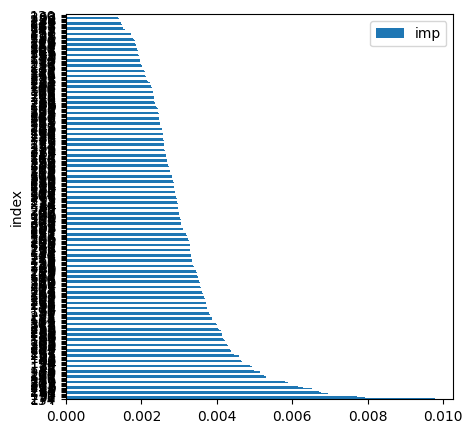

In [138]:
(
    pd.DataFrame({'imp' : model.feature_importances_})
    .reset_index()
    .sort_values('imp', ascending=False)
 .plot.barh(y='imp', x='index', figsize=(5,5))
)


#### Linear

In [146]:
from sklearn.linear_model import LogisticRegression


In [230]:
model = LogisticRegression(random_state=11, tol=1e-5, max_iter=1000)
model.fit(X_train[[f'feature_{i}' for i in range(embeddings.shape[1])]], y_train)

LogisticRegression(max_iter=1000, random_state=11, tol=1e-05)

In [231]:
f1_score(y_test, model.predict(X_test), average='weighted')

0.25885765825795815

### Prediction

In [372]:
# compute embeddings

processed_reviews_unlabeled_burger_king[[f'feature_{i}' for i in range(312)]] = \
    sentence_transformer.encode(processed_reviews_unlabeled_burger_king.review_processed.values)

processed_reviews_unlabeled_rostics[[f'feature_{i}' for i in range(312)]] = \
    sentence_transformer.encode(processed_reviews_unlabeled_rostics.review_processed.values)

# processed_reviews_unlabeled_vit[[f'feature_{i}' for i in range(312)]] = \
#     sentence_transformer.encode(processed_reviews_unlabeled_vit.review_processed.values)

# processed_reviews_unlabeled_dodo[[f'feature_{i}' for i in range(312)]] = \
#     sentence_transformer.encode(processed_reviews_unlabeled_dodo.review_processed.values)

In [378]:
# compute predictions

predicted_reviews_unlabeled_rostics = (
    processed_reviews_unlabeled_rostics
    .copy()
    .assign(
        preds = model.predict(processed_reviews_unlabeled_rostics[[f'feature_{i}' for i in range(312)]])
    )
)
predicted_reviews_unlabeled_rostics = (
    predicted_reviews_unlabeled_rostics
    .assign(
        type_preds = (
            pd.DataFrame(predicted_reviews_unlabeled_rostics.preds)
            .replace(num_to_type_dict)
            .values
            .reshape(-1)
        )
    )
    .loc[:,['date', 'review', 'rating', 'review_processed', 'preds', 'type_preds']]
)
predicted_reviews_unlabeled_rostics.to_csv('../data/scored/rostics.csv')

In [380]:
predicted_reviews_unlabeled_burger_king = (
    processed_reviews_unlabeled_burger_king
    .copy()
    .assign(
        preds = model.predict(processed_reviews_unlabeled_burger_king[[f'feature_{i}' for i in range(312)]])
    )
)
predicted_reviews_unlabeled_burger_king = (
    predicted_reviews_unlabeled_burger_king
    .assign(
        type_preds = (
            pd.DataFrame(predicted_reviews_unlabeled_burger_king.preds)
            .replace(num_to_type_dict)
            .values
            .reshape(-1)
        )
    )
)

predicted_reviews_unlabeled_burger_king.to_csv('../data/scored/burger_king.csv')

In [375]:
predicted_reviews_unlabeled_burger_king[predicted_reviews_unlabeled_burger_king["type_preds"] == "Локация ПБО"].review.tolist()[:6]

['Доставка в Якутске не работает ( по крайней мере на наш адрес ).',
 'Не отображает местонахождение курьера, курьер приносит ледяной заказ после того как полтора часа где-то гулял, и убегает, делая вид, что не понимает по-русски, поддержка пишет отписки',
 'Указываешь адрес доставки один,а в приложение адрес изменяется без объяснения причин.',
 'При оформлении заказа доставкой часть товара теряется из корзины',
 'доставка как будто в Китай 499 рублей .У меня заказ дешевле стоит',
 'Мало того что все стоит дороже, если заказывать через доставку, так ещё и за саму доставку просят 400р']